# Exploratory analysis : NLP FOMC Project

In [126]:
#!pip install wordcloud

In [238]:
import numpy as np
import pandas as pd
from urllib import request
import bs4
from wordcloud import WordCloud, STOPWORDS 
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import re

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [239]:
df = pd.read_csv("/Users/h2jw/Documents/GitHub/NLP-FOMC/RA_project/final_df_v4.csv", low_memory=True)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [240]:
df  = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1','Unnamed: 0.1.1.1'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126782 entries, 0 to 126781
Data columns (total 38 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date               126782 non-null  object 
 1   interlocutor_name  126782 non-null  object 
 2   statement _size    126782 non-null  int64  
 3   statement          126725 non-null  object 
 4   statement_number   126782 non-null  object 
 5   chair_in_charge    126782 non-null  object 
 6   score_acadam       126782 non-null  float64
 7   score_hostile      126782 non-null  float64
 8   score_econo        126782 non-null  float64
 9   score_virtue       126782 non-null  float64
 10  score_vice         126782 non-null  float64
 11  score_hawkish      126782 non-null  float64
 12  score_posi         126782 non-null  float64
 13  score_affi         126782 non-null  float64
 14  score_uncert       126782 non-null  float64
 15  Affil              126782 non-null  float64
 16  Ho

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [168]:
df.head()

,Date,interlocutor_name,statement _size,statement,statement_number,chair_in_charge,score_acadam,score_hostile,score_econo,score_virtue,...,NUMB,Yes,No,Negate,SureLw,If,NotLw,RspGain,ABS,Causal
0,1976-08-17,CHAIRMAN BURNS,41,we are ready to start our meeting this morning...,statement_0,CHAIRMAN BURNS,0.0,0.04878,0.024390,0.048780,...,0.048780,0.0,0.02439,0.024390,0.048780,0.000000,0.024390,0.02439,0.024390,0.024390
1,1976-08-17,MR HOLMES,2,statementsee appendix,statement_1,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,1976-08-17,MR BLACK,27,alan do you think that through realignment of ...,statement_2,CHAIRMAN BURNS,0.0,0.00000,0.037037,0.037037,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.074074,0.037037
3,1976-08-17,MR HOLMES,49,there are two alternatives one that everybody ...,statement_3,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,...,0.081633,0.0,0.00000,0.020408,0.020408,0.040816,0.020408,0.00000,0.061224,0.020408
4,1976-08-17,MR BLACK,8,which do you think would be more likely?,statement_4,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.125000,0.000000


## Preprocessing

La base s'arrête en 2014, on va rajouter le scrapping de 2015 avec les codes contenus dans `codes scrapping`.

In [8]:
# add 2015 update

### Chairs

In [107]:
pd.unique(df.chair_in_charge)

array(['CHAIRMAN BURNS', 'CHAIRMAN MILLER', 'CHAIRMAN VOLCKER',
       'CHAIRMAN GREENSPAN', 'CHAIRMAN BERNANKE', 'CHAIR YELLEN'],
      dtype=object)

Text(0.5, 0, 'Chair person')

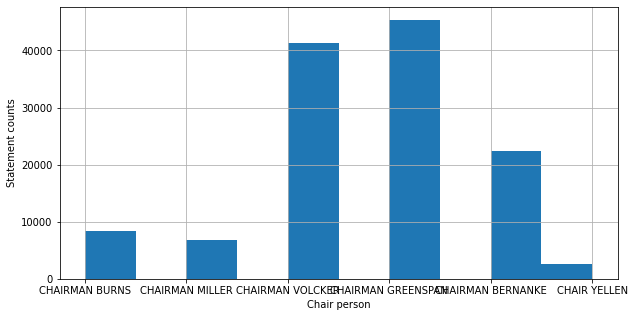

In [114]:
plt.figure(figsize=(10,5))
df['chair_in_charge'].hist()
plt.ylabel('Statement counts')
plt.xlabel('Chair person')

In [134]:
#pd.unique(df['interlocutor_name'])

In [169]:
def name_cleaning(name_list):
    # Removing punctuations in string
    # Using regex
    cleaned = []
    stopname_list=['CHAIRMAN', 'MS', 'VICE', 'MR']
    for name in name_list:
        res = re.sub(r'[^\w\s]', '', name)
        # printing result
        # print("The string after punctuation filter : " + res)
        
        res = ' '.join([word for word in res.split() if word not in stopname_list])
        cleaned.append(res)
    return cleaned
def get_role(name_list):
    role = []
    stopname_list=['CHAIRMAN', 'MS', 'VICE', 'MR']
    for name in name_list:
        res = re.sub(r'[^\w\s]', '', name)
        res = ' '.join([word for word in res.split() if word in stopname_list])
        role.append(res)
        
    return role

In [170]:
df['role_int']= get_role(df.interlocutor_name.tolist())
df['interlocutor_name']=name_cleaning(df.interlocutor_name.tolist())

In [180]:
pd.unique(df.interlocutor_name)

array(['BURNS', 'HOLMES', 'BLACK', 'PARDEE', 'COLDWELL', 'PARTEE',
       'EASTBURN', 'WALLICH', 'JACKSON', 'GARDNER', 'BAUGHMAN', 'GRAMLEY',
       'WINN', 'KIMBREL', 'AXILROD', 'MAYO', 'WILLIAMS', 'GUFFEY',
       'MORRIS', 'VOLCKER', 'MACLAURY', 'BROIDA', 'ZEISEL', 'BALLES',
       'STERNLIGHT', 'LILLY', 'ROOS', 'MACCLAURY', 'PAULUS', 'REYNOLDS',
       'VAN', 'KICHLINE', 'WILLES', 'FOSSUM', 'MEEK', 'ALTMANN', 'TRUMAN',
       'RANKIN', 'COYNE', 'SICILIANO', 'SMOOT', 'WILLIS', 'ETTIN',
       'GUENTHER', 'WALLACE', 'MAYOMR', 'MILLER', 'DENKLER', 'MORIARTY',
       'CZERWINSKI', 'TEETERS', 'OCONNELL', 'BAUGHWJV', 'MACDONALD',
       'ALTMA', 'HOMES', 'GAINOR', 'WALLJCH', 'MCINTOSH', 'GREENE',
       'RICE', 'FARNSWORTH', 'ROBINSON', 'TIMLEN', 'PRELL', 'SCHULTZ',
       'VOLCRER', 'KIMEREL', 'SCWLTZ', 'VOLCKFR', 'BECK', 'SIMPSON',
       'LINDSEY', 'KERAN', 'FORRESTAL', 'SOLOMON', 'PETERSEN', 'FORD',
       'KEIR', 'CORRIGAN', 'GRALEY', 'OLTMAN', 'BOEHNE', 'BOYKIN',
       'DOYLE', 'K

In [172]:
df_small = df.head(40000)
df_small = df_small.groupby('interlocutor_name').agg({'statement':'count'})

<AxesSubplot:ylabel='statement'>

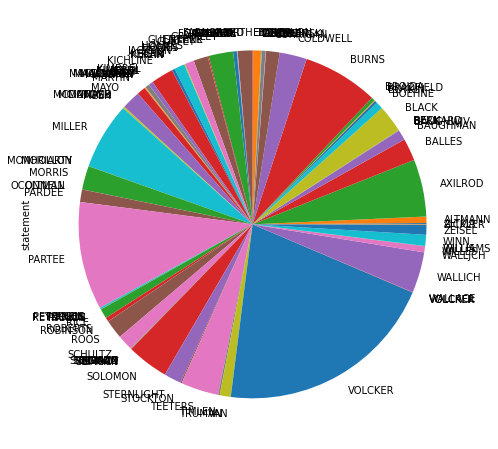

In [179]:
fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor('white')
df_small.statement.plot.pie()

### Statements

In [241]:
df.statement = df.statement.astype('string')

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [201]:
df['statement2']= df['statement']
df.statement = df.statement.str.replace(' ', ',')
df.statement.head()

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    we,are,ready,to,start,our,meeting,this,morning...
1                                statementsee,appendix
2    alan,do,you,think,that,through,realignment,of,...
3    there,are,two,alternatives,one,that,everybody,...
4             which,do,you,think,would,be,more,likely?
Name: statement, dtype: string

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

On va "nettoyer" les statements des STOPWORDS.

In [242]:
df_lda = df.dropna()
df_lda['cleaned_statement'] = df_lda['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /Users/h2jw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-242-c56bc82ae417>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lda['cleaned_statement'] = df_lda['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [245]:
df_lda[['statement', 'cleaned_statement']].head()

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,statement,cleaned_statement
0,we are ready to start our meeting this morning...,ready start meeting morning first item busines...
1,statementsee appendix,statementsee appendix
2,alan do you think that through realignment of ...,alan think realignment currencies european com...
3,there are two alternatives one that everybody ...,two alternatives one everybody goes floats sep...
4,which do you think would be more likely?,think would likely?


/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    we are ready to start our meeting this morning...
1                                statementsee appendix
2    alan do you think that through realignment of ...
3    there are two alternatives one that everybody ...
4             which do you think would be more likely?
Name: statement, dtype: object

In [90]:
df.statement.str.lower().str.split()

0         [we,are,ready,to,start,our,meeting,this,mornin...
1                                   [statementsee,appendix]
2         [alan,do,you,think,that,through,realignment,of...
3         [there,are,two,alternatives,one,that,everybody...
4                [which,do,you,think,would,be,more,likely?]
                                ...                        
126777    [no,worries,it,happened,one,time,under,chairma...
126778    [thank,you,okay,i,think,the,main,open,issue,in...
126779    [this,vote,as,chair,yellen,indicated,will,be,o...
126780    [okay,thank,you,very,much,and,let,me,confirm,t...
126781             [thank,you,madam,chair,december,–,,,of,]
Name: statement, Length: 126782, dtype: object

## Quelques statistiques descriptives...

- Wordclouds par "Chair in charge"

In [7]:
def nuage_de_mots(text): 
    wordcloud = WordCloud(background_color="white",
                          relative_scaling = 1.0,
                          width=1280, 
                          height=800, 
                          stopwords = STOPWORDS # mots à ne pas prendre en compte dans le nuage
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()   
    

In [94]:
df.statement

0         we,are,ready,to,start,our,meeting,this,morning...
1                                     statementsee,appendix
2         alan,do,you,think,that,through,realignment,of,...
3         there,are,two,alternatives,one,that,everybody,...
4                  which,do,you,think,would,be,more,likely?
                                ...                        
126777    no,worries,it,happened,one,time,under,chairman...
126778    thank,you,okay,i,think,the,main,open,issue,in,...
126779    this,vote,as,chair,yellen,indicated,will,be,on...
126780    okay,thank,you,very,much,and,let,me,confirm,th...
126781               thank,you,madam,chair,december,–,,,of,
Name: statement, Length: 126782, dtype: string

In [115]:
df_small = df.head(40000)

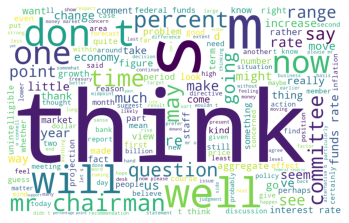

Wordcloud associé à la chair BURNS


In [116]:
df_statement = df_small.groupby('chair_in_charge')['statement'].apply(','.join)
nuage_de_mots(df_statement.iloc[[0]][0])  
print("Wordcloud associé à la chair BURNS")

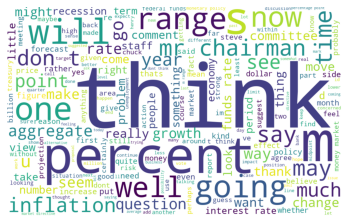

Wordcloud associé à la chair MILLER


In [118]:
nuage_de_mots(df_statement.iloc[[1]][0]) 
print("Wordcloud associé à la chair MILLER")

In [73]:
df_statement.iloc[[0]]['cleaned_statement'][0][0]

'we,are,ready,to,start,our,meeting,this,morning,the,first,item,of,business,as,always,is,to,act,on,the,minutes,of,the,last,meeting,motion,to,approve,seconded,the,motion,has,been,made,and,duly,seconded,no,objections,heard'

In [195]:
df_statement

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


chair_in_charge
CHAIRMAN BURNS      we,are,ready,to,start,our,meeting,this,morning...
CHAIRMAN MILLER     well,he,can,join,us,when,he,arrives,first,we,c...
CHAIRMAN VOLCKER    i,might,say,for,the,benefit,of,those,who,have,...
Name: statement, dtype: object

### Tests de LDA 

- LDA sur l'ensemble des statements. 
- LDA sur Chair Burns et Chair Miller

In [183]:
#!pip install pyldavis

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [182]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn


def LDA_on_dataset(series, n_topic): #notre LDA prend en entrée le series.dataframe contenant l'information textuelle 
                                      #et le nombre de topic à modéliser
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=1000)
    tfidf = tfidf_vectorizer.fit_transform(series)

    lda = LatentDirichletAllocation(n_components=n_topic, max_iter=5,
                                  learning_method='online',
                                  learning_offset=50.,
                                  random_state=0)
    lda.fit(tfidf)
    LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=n_topic, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

    tf_feature_names = tfidf_vectorizer.get_feature_names()

    return pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)



In [ ]:
print('Statement : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_lda.cleaned_statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement : 



In [251]:
df_burns = df_lda[df_lda.chair_in_charge == 'CHAIRMAN BURNS']
df_miller = df_lda[df_lda.chair_in_charge == 'CHAIRMAN MILLER']

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [255]:
print('Statement Burns : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_burns.cleaned_statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Burns : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.103025  0.019884       1        1  48.242706
3      0.122128  0.173416       2        1  18.392287
0      0.029734 -0.204654       3        1  16.517910
1     -0.394276  0.035087       4        1   9.586978
4      0.139388 -0.023734       5        1   7.260120, topic_info=       Term        Freq       Total Category  logprob  loglift
568      mr  572.000000  572.000000  Default  30.0000  30.0000
897   thank  272.000000  272.000000  Default  29.0000  29.0000
647  please  237.000000  237.000000  Default  28.0000  28.0000
898    that  269.000000  269.000000  Default  27.0000  27.0000
969    well  297.000000  297.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
365   going   14.845332  113.768059   Topic5  -4.8784   0.5863
963     way   13.173022   76.157216   Topic5  -4.9979   0.8681
601     one   12.043567  138.698717   Topic5  -5.0875   0.1790
355     get   11.702951   91.952807   Topic5  -5.1162   0.5613
281    even   11.545003   58.570160   Topic5  -5.1298   0.9988

[308 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5         2  0.840347  accounts
5         3  0.076395  accounts
7         1  0.104696       act
7         3  0.889914       act
16        1  0.092740  adjusted
...     ...       ...       ...
997       5  0.500304       yet
999       1  0.379425       you
999       2  0.440622       you
999       3  0.146874       you
999       4  0.036719       you

[581 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2, 5])

In [254]:
print('Statement Miller : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_miller.cleaned_statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Miller : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.071625 -0.061479       1        1  65.769742
4     -0.053794  0.296858       2        1  10.731505
3     -0.148441 -0.082027       3        1   9.567390
0      0.339093 -0.026251       4        1   7.659058
1     -0.065233 -0.127100       5        1   6.272304, topic_info=        Term        Freq       Total Category  logprob  loglift
872    thank  247.000000  247.000000  Default  30.0000  30.0000
992      yes  240.000000  240.000000  Default  29.0000  29.0000
141    chuck  109.000000  109.000000  Default  28.0000  28.0000
737    right  119.000000  119.000000  Default  27.0000  27.0000
874    thats  112.000000  112.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
328  foreign   20.028476   50.022509   Topic5  -4.1412   1.8537
563      new   15.653411   34.592611   Topic5  -4.3876   1.9761
482     line   15.689073   35.727537   Topic5  -4.3854   1.9461
178    could   16.514572   96.635508   Topic5  -4.3341   1.0023
958     well   12.956112  159.204653   Topic5  -4.5768   0.2604

[246 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
22        2  0.860648      agenda
24        1  0.979524  aggregates
29        1  0.036834        alan
29        2  0.847191        alan
29        3  0.073669        alan
...     ...       ...         ...
995       1  0.041333        york
995       5  0.909322        york
996       1  0.232631         you
996       2  0.021148         you
996       3  0.740188         you

[404 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 2])

In [256]:
df_greenspan = df_lda[df_lda.chair_in_charge == 'CHAIRMAN GREENSPAN']

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [257]:
print('Statement Greenspan : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_greenspan.cleaned_statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Miller : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.193199  0.015443       1        1  40.456062
0      0.209096  0.008848       2        1  39.608957
3     -0.197378 -0.381319       3        1   6.860028
4      0.155182  0.094060       4        1   6.764059
2     -0.360099  0.262967       5        1   6.310895, topic_info=           Term         Freq        Total Category  logprob  loglift
645   president  4998.000000  4998.000000  Default  30.0000  30.0000
358    governor  2965.000000  2965.000000  Default  29.0000  29.0000
747       right  1108.000000  1108.000000  Default  28.0000  28.0000
886       thank  1075.000000  1075.000000  Default  27.0000  27.0000
887        that   997.000000   997.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
744     revised     0.283578    46.598261   Topic5 -10.4362  -2.3389
991         yes     0.289667  1034.924273   Topic5 -10.4150  -5.4182
949        vice     0.288644   416.676684   Topic5 -10.4185  -4.5120
224  discussion     0.287930   296.978092   Topic5 -10.4210  -4.1758
313       first     0.286796   389.133965   Topic5 -10.4249  -4.4500

[287 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
10        1  0.925301  activity
10        2  0.071177  activity
22        1  0.066081     agree
22        2  0.451174     agree
22        3  0.480797     agree
...     ...       ...       ...
991       2  0.096625       yes
997       1  0.123265       you
997       2  0.876551       you
998       2  0.984522     youre
998       5  0.009467     youre

[461 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 3])